In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d computingvictor/transactions-fraud-datasets
!unzip -q transactions-fraud-datasets.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/computingvictor/transactions-fraud-datasets
License(s): apache-2.0
 96% 335M/348M [00:00<00:00, 685MB/s]
100% 348M/348M [00:00<00:00, 680MB/s]


In [ ]:
import os
import json
import csv
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, to_date, when
from pyspark.sql.types import FloatType


In [ ]:
os.makedirs("/content/working", exist_ok=True)

In [ ]:
with open('/content/mcc_codes.json', 'r') as json_file:
    json_data = json.load(json_file)
data_list = [{"mcc_code": key, "description": value} for key, value in json_data.items()]
with open('/content/working/mcc_codes.csv', 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=['mcc_code', 'description'])
    writer.writeheader()
    writer.writerows(data_list)

with open('/content/train_fraud_labels.json', 'r') as json_file:
    json_data = json.load(json_file)
target_data = json_data['target']
data_list = [{"transaction_id": key, "fraud_label": value} for key, value in target_data.items()]
with open('/content/working/train_fraud_labels.csv', 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=['transaction_id', 'fraud_label'])
    writer.writeheader()
    writer.writerows(data_list)

In [ ]:
df_transactions = pl.read_csv("/content/transactions_data.csv")
df_fraud_labels = pl.read_csv("/content/working/train_fraud_labels.csv")
df_filtered_transactions = df_transactions.join(
    df_fraud_labels,
    left_on="id",
    right_on="transaction_id",
    how="inner"
)
df_cards = pl.read_csv("/content/cards_data.csv")
df_combined = df_filtered_transactions.join(
    df_cards,
    left_on="card_id",
    right_on="id",
    how="left"
)
card_brand_counts = df_combined.group_by("card_brand").count()
print(card_brand_counts)

# output_df = df_combined.select([
#     "id", "date", "client_id", "card_id", "amount",
#     "merchant_id", "card_brand", "fraud_label", "mcc"
# ])
output_df = df_combined.filter(pl.col("card_brand") == "Amex").select([
    "id", "date", "client_id", "card_id", "amount",
    "merchant_id", "card_brand", "fraud_label", "mcc"
])
output_path = "/content/working/filtered_transactions.csv"
output_df.write_csv(output_path)
print(f"Đã lưu {output_df.height} giao dịch vào '{output_path}'")


/tmp/ipython-input-5-1670585272.py:16: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  card_brand_counts = df_combined.group_by("card_brand").count()


shape: (4, 2)
┌────────────┬─────────┐
│ card_brand ┆ count   │
│ ---        ┆ ---     │
│ str        ┆ u32     │
╞════════════╪═════════╡
│ Amex       ┆ 572424  │
│ Visa       ┆ 3321615 │
│ Discover   ┆ 225242  │
│ Mastercard ┆ 4795682 │
└────────────┴─────────┘
Đã lưu 572424 giao dịch vào '/content/working/filtered_transactions.csv'


In [ ]:
spark = SparkSession.builder.appName("DataPreprocessing").getOrCreate()
df_cards = spark.read.csv("/content/cards_data.csv", header=True, inferSchema=True)
df_users = spark.read.csv("/content/users_data.csv", header=True, inferSchema=True)
df_filtered_transactions = spark.read.csv(output_path, header=True, inferSchema=True)

# Làm sạch cards
df_cards = df_cards.drop("card_on_dark_web")
df_cards = df_cards.withColumn("credit_limit", regexp_replace(col("credit_limit"), "[\$,]", "").cast(FloatType()))
df_cards = df_cards.withColumn("acct_open_date", to_date(col("acct_open_date"), "MM/yyyy"))
df_cards = df_cards.withColumn("PIN_Change_Due", when(col("year_pin_last_changed") < 2025 - 7, "Yes").otherwise("No"))

# Làm sạch users
df_users = df_users.withColumn("per_capita_income", regexp_replace(col("per_capita_income"), "[\$,]", "").cast(FloatType()))
df_users = df_users.withColumn("yearly_income", regexp_replace(col("yearly_income"), "[\$,]", "").cast(FloatType()))
df_users = df_users.withColumn("total_debt", regexp_replace(col("total_debt"), "[\$,]", "").cast(FloatType()))
df_users = df_users.withColumn("retirement_status", when(col("current_age") >= col("retirement_age"), "Retired").otherwise("Not Retired"))
df_users = df_users.withColumn("age_group",
    when(col("current_age") <= 30, "18-30")
    .when(col("current_age") <= 45, "31-45")
    .when(col("current_age") <= 60, "46-60")
    .otherwise("60+")
)
df_users = df_users.withColumn("Debt_to_Income_Ratio", col("total_debt") / col("yearly_income"))

# Làm sạch giao dịch
df_filtered_transactions = df_filtered_transactions.withColumn("amount", regexp_replace(col("amount"), "[\$,]", "").cast(FloatType()))


In [ ]:
print("\nXem trước dữ liệu:")
print("Cards:")
df_cards.show(5, truncate=False)
print("Users:")
df_users.show(5, truncate=False)
print("Giao dịch lọc:")
df_filtered_transactions.show(5, truncate=False)


Xem trước dữ liệu:
Cards:
+----+---------+----------+---------------+----------------+-------+---+--------+----------------+------------+--------------+---------------------+--------------+
|id  |client_id|card_brand|card_type      |card_number     |expires|cvv|has_chip|num_cards_issued|credit_limit|acct_open_date|year_pin_last_changed|PIN_Change_Due|
+----+---------+----------+---------------+----------------+-------+---+--------+----------------+------------+--------------+---------------------+--------------+
|4524|825      |Visa      |Debit          |4344676511950444|12/2022|623|YES     |2               |24295.0     |2002-09-01    |2008                 |Yes           |
|2731|825      |Visa      |Debit          |4956965974959986|12/2020|393|YES     |2               |21968.0     |2014-04-01    |2014                 |Yes           |
|3701|825      |Visa      |Debit          |4582313478255491|02/2024|719|YES     |2               |46414.0     |2003-07-01    |2004                 |Yes  

In [ ]:
print("\nSố dòng:")
print(f"- Cards: {df_cards.count()}")
print(f"- Users: {df_users.count()}")
print(f"- Filtered Transactions: {df_filtered_transactions.count()}")


Số dòng:
- Cards: 6146
- Users: 2000
- Filtered Transactions: 572424


In [ ]:
from pyspark.sql.functions import trim


In [ ]:
df_temp = df_filtered_transactions.join(
    df_cards, df_filtered_transactions["card_id"] == df_cards["id"], "left"
).select(
    df_filtered_transactions["id"].alias("transaction_id"),
    df_filtered_transactions["client_id"],
    df_filtered_transactions["amount"],
    df_filtered_transactions["fraud_label"],
    df_filtered_transactions["mcc"],
    df_cards["credit_limit"]
)

df_combined = df_temp.join(
    df_users, df_temp["client_id"] == df_users["id"], "left"
).select(
    df_temp["transaction_id"],
    df_temp["client_id"],
    df_temp["amount"],
    df_temp["fraud_label"],
    df_temp["mcc"],
    df_temp["credit_limit"],
    df_users["gender"],
    df_users["retirement_status"],
    df_users["current_age"],
    df_users["per_capita_income"],
    df_users["yearly_income"],
    df_users["total_debt"],
    df_users["Debt_to_Income_Ratio"]
)

df_combined = df_combined.filter(trim(col("fraud_label")).isin(["Yes", "No"]))

label_counts = df_combined.groupBy("fraud_label").count()
total = df_combined.count()

label_weights = label_counts.withColumn(
    "weight", (total / col("count")).cast("float")
)

df_combined = df_combined.join(label_weights, "fraud_label", "left")

print("Đã kết hợp dữ liệu và tính trọng số (weight) để cân bằng label:")
df_combined.groupBy("fraud_label", "weight").count().show()


Đã kết hợp dữ liệu và tính trọng số (weight) để cân bằng label:
+-----------+---------+------+
|fraud_label|   weight| count|
+-----------+---------+------+
|         No|1.0016168|571500|
|        Yes| 619.5065|   924|
+-----------+---------+------+



# random forest


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType


In [ ]:
categorical_cols = ["mcc", "gender", "retirement_status"]
numerical_cols = [
    "amount", "current_age", "per_capita_income", "yearly_income",
    "total_debt", "Debt_to_Income_Ratio", "credit_limit"
]

indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep") for col in categorical_cols]
label_indexer = StringIndexer(inputCol="fraud_label", outputCol="label", handleInvalid="skip")

assembler = VectorAssembler(inputCols=[col + "_index" for col in categorical_cols] + numerical_cols,
                            outputCol="raw_features", handleInvalid="keep")
scaler = StandardScaler(inputCol="raw_features", outputCol="features", withStd=True, withMean=True)


In [ ]:
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    weightCol="weight",
    numTrees=100,
    maxDepth=15,
    subsamplingRate=1.0,
    seed=42
)

pipeline = Pipeline(stages=indexers + [label_indexer, assembler, scaler, rf])
train_data, test_data = df_combined.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_data)

In [ ]:
predictions = model.transform(test_data)

evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"AUC trên tập test: {auc:.4f}")


AUC trên tập test: 0.8494


In [ ]:
confusion_matrix = predictions.groupBy("label", "prediction").count().collect()


print("Confusion Matrix:")
for row in confusion_matrix:
    print(f"Label {int(row['label'])}, Prediction {int(row['prediction'])} = {row['count']}")

Confusion Matrix:
Label 1, Prediction 1 = 42
Label 0, Prediction 1 = 1452
Label 1, Prediction 0 = 133
Label 0, Prediction 0 = 112888


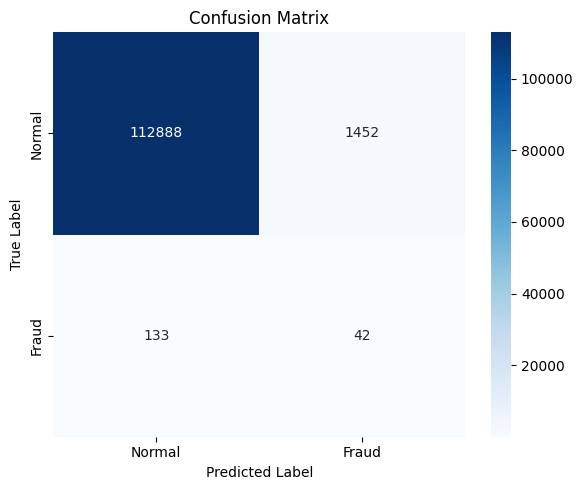

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Tạo ma trận nhầm lẫn
cm = np.array([[112888, 1452],
               [133, 42]])

# Tạo nhãn cho trục
labels = ['Normal', 'Fraud']

# Vẽ heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

# UDF lấy xác suất class 1
def get_class1_prob(prob):
    return float(prob[1])

get_class1_prob_udf = udf(get_class1_prob, FloatType())

# Tạo cột mới chứa xác suất class 1
predictions = predictions.withColumn("prob_class1", get_class1_prob_udf(col("probability")))


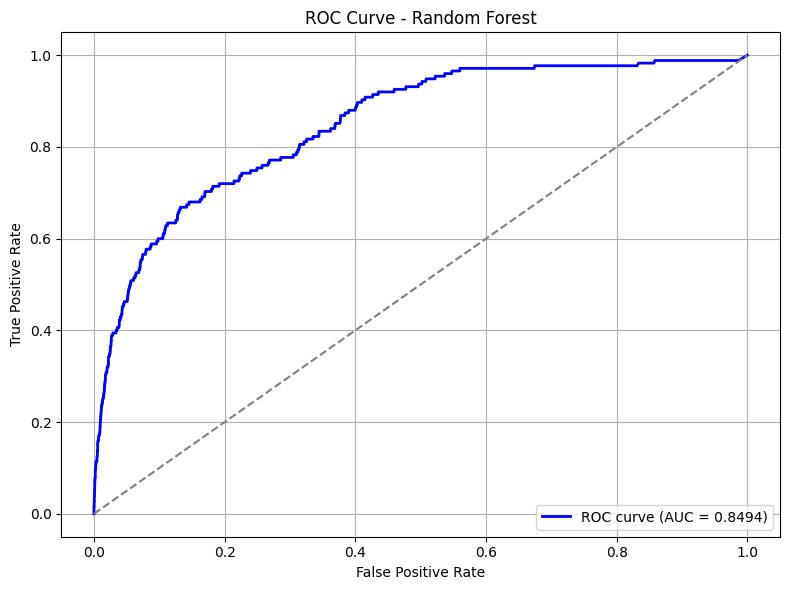

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Chuyển sang Pandas
pdf = predictions.select("label", "prob_class1").toPandas()

# Tính FPR, TPR, AUC
fpr, tpr, thresholds = roc_curve(pdf["label"], pdf["prob_class1"])
roc_auc = auc(fpr, tpr)

# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# Bước 1: Chuyển sang Pandas
pdf = predictions.select("label", "prediction", "probability").toPandas()

# Bước 2: Trích xác suất class 1
pdf["prob_class1"] = pdf["probability"].apply(lambda x: float(x[1]))

# Bước 3: Tính các chỉ số
accuracy = accuracy_score(pdf["label"], pdf["prediction"])
precision = precision_score(pdf["label"], pdf["prediction"])
recall = recall_score(pdf["label"], pdf["prediction"])
f1 = f1_score(pdf["label"], pdf["prediction"])
auc = roc_auc_score(pdf["label"], pdf["prob_class1"])

# Bước 4: Lập bảng tổng hợp
metrics_table = pd.DataFrame([{
    "Model": "Random Forest",
    "Accuracy": round(accuracy, 4),
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "F1-score": round(f1, 4),
    "AUC": round(auc, 4)
}])

# Hiển thị bảng
import IPython.display as display
display.display(metrics_table)


,Model,Accuracy,Precision,Recall,F1-score,AUC
0,Random Forest,0.9862,0.0281,0.24,0.0503,0.8494


#save

In [ ]:
# model_path = "/content/random_forest_model"
# model.save(model_path)
# print("Mô hình đã được lưu vào:", model_path)


In [ ]:
# import shutil

# zip_path = "/content/random_forest_model.zip"
# shutil.make_archive("/content/random_forest_model", 'zip', model_path)
# print("Đã nén mô hình thành:", zip_path)

In [ ]:
# from google.colab import files
# files.download(zip_path)


# isolatoin forest

In [ ]:
!pip install scikit-learn --quiet


In [ ]:
feature_cols = [
    "amount", "current_age", "per_capita_income", "yearly_income",
    "total_debt", "Debt_to_Income_Ratio", "credit_limit"
]


df_pandas = df_combined.select(feature_cols).toPandas()
df_pandas = df_pandas.dropna()


In [ ]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.001,
    random_state=42,
    n_jobs=-1
)

iso_forest.fit(df_pandas)
preds = iso_forest.predict(df_pandas)


df_pandas["anomaly"] = preds


In [ ]:
anomalies = df_pandas[df_pandas["anomaly"] == -1]
print(f"Phát hiện {len(anomalies)} giao dịch nghi ngờ trong {len(df_pandas)} dòng dữ liệu.")
anomalies.head()


Phát hiện 571 giao dịch nghi ngờ trong 572424 dòng dữ liệu.


,amount,current_age,per_capita_income,yearly_income,total_debt,Debt_to_Income_Ratio,credit_limit,anomaly
1963,1393.130005,51,55274.0,112695.0,35135.0,0.311771,22800.0,-1
4221,590.539978,49,46461.0,94733.0,0.0,0.000000,26900.0,-1
4490,415.089996,32,26431.0,53890.0,252106.0,4.678159,17800.0,-1
6662,719.440002,49,46461.0,94733.0,0.0,0.000000,26900.0,-1
8630,828.299988,49,46461.0,94733.0,0.0,0.000000,26900.0,-1


# so sánh

In [ ]:
# Dữ liệu Pandas gồm đặc trưng + fraud_label
df = df_combined.select(feature_cols + ["fraud_label"]).toPandas()

# Chạy Isolation Forest và thêm cột anomaly
iso_forest = IsolationForest(n_estimators=100, contamination=0.001, random_state=42, n_jobs=-1)
df = df.dropna()
iso_forest.fit(df[feature_cols])
df["anomaly"] = iso_forest.predict(df[feature_cols])  # -1 = bất thường


In [ ]:
df["fraud_label_bin"] = df["fraud_label"].apply(lambda x: 1 if x == "Yes" else 0)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# anomaly: -1 = bất thường → ta gán = 1 để dễ so sánh
df["anomaly_bin"] = df["anomaly"].apply(lambda x: 1 if x == -1 else 0)

print(confusion_matrix(df["fraud_label_bin"], df["anomaly_bin"]))
print(classification_report(df["fraud_label_bin"], df["anomaly_bin"]))

[[570930    570]
 [   923      1]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    571500
           1       0.00      0.00      0.00       924

    accuracy                           1.00    572424
   macro avg       0.50      0.50      0.50    572424
weighted avg       1.00      1.00      1.00    572424

